# Blind deconvolution

In [1]:
import sys
import os
# sys.path.insert(1, 'C:/Users/Johan/Documents/FAU_Masterarbeit/Implementation')
sys.path.insert(1, 'C:/Users/jo77pihe/Documents/MasterThesis_OfSpinesAndDendrites')
from deconv import REGISTRY
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
from matplotlib.colors import LogNorm
import imagequalitymetrics
import tifffile as tif
from scipy.signal import convolve
from skimage import io
from normalize import PercentileNormalizer
from nutil.plot import paperStyle

Num GPUs Available:  1


In [2]:
data_path = 'D:/jo77pihe/Registered/20220204_Denoising'
deconved_path ='D:/jo77pihe/Registered/20220211_Blind_RL/Preprocessing'
normalizer = PercentileNormalizer()
iqm = imagequalitymetrics.ImageQualityMetrics()

## 0 Preprocessing: Denoising

Preprocessed images obtained in ./Denoising.ipynb

#### *Gaussian Smoothing*

Has Hyperparameter σ =[0.5,1,...,3.0] --> how does it effect the raw data? 

In [3]:
gauss_path = os.path.join(data_path, 'GaussianFilter')

#### *Neighbor2Neighbor*

Huang, Tao, et al. "Neighbor2Neighbor: Self-Supervised Denoising from Single Noisy Images." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2021.

In [4]:
n2n_path=os.path.join(data_path, 'Neighbor2Neighbor')

#### *Bilateral Filter*
C. Tomasi and R. Manduchi. 1998. Bilateral Filtering for Gray and Color Images. In: Proceedings of the Sixth International Conference on Computer Vision (ICCV ’98). IEEE Computer Society, Washington DC

In [5]:
bil_path = os.path.join(data_path, 'BilateralFilter')

## 1 Effect of denoising on deconvolution

### 1.1 Obtain results

No. iterations, empirically derived: 6,3,3

#### 1.1.1 Gaussian Smoothing

In [6]:
args = {}
args['data_path']= ''
args['source_folder']= gauss_path
args['target_folder']= ''
args['psf'] = "../PSF"

args['result_path'] = 'D:/jo77pihe/Registered/20220211_Blind_RL/Preprocessing/Gaussian'
blind_rl = REGISTRY['BlindRL'](args)
blind_rl.predict(args['source_folder'], 6, 3, 3, 0.0, eval_img_steps = False, save_intermediate_res= True, parallel=True)

#### 1.1.2 Neighbor2Neighbor

In [7]:
args = {}
args['data_path']= ''
args['source_folder']= n2n_path
args['target_folder']= ''
args['psf'] = "../PSF"

args['result_path'] = 'D:/jo77pihe/Registered/20220211_Blind_RL/Preprocessing/N2N'
blind_rl = REGISTRY['BlindRL'](args)
blind_rl.predict(args['source_folder'], 6, 3, 3, sigma=0.0, eval_img_steps = False, save_intermediate_res= True, parallel=True)

#### 1.1.3 Bilateral Filter

In [8]:
args = {}
args['data_path']= ''
args['source_folder']= bil_path
args['target_folder']= ''
args['psf'] = "../PSF"

args['result_path'] = 'D:/jo77pihe/Registered/20220211_Blind_RL/Preprocessing/Bilateral'
blind_rl = REGISTRY['BlindRL'](args)
blind_rl.predict(args['source_folder'], 6, 3, 3, sigma=0.0, eval_img_steps = False, save_intermediate_res= True, parallel=True)

#### 1.1.4 Ground truth (without denoising)

In [52]:
args = {}
args['data_path']= ''
args['source_folder']= os.path.join(data_path, 'Raw')
args['target_folder']= ''
args['psf'] = "../PSF"

args['result_path'] = 'D:/jo77pihe/Registered/20220211_Blind_RL/Preprocessing/NoPre'
blind_rl = REGISTRY['BlindRL'](args)
blind_rl.predict(args['source_folder'], 6, 3, 3, sigma=0.0, eval_img_steps = False, save_intermediate_res= True, parallel=True)

### 1.2 Evaluation

#### 1.2.1 Visual inspection

Tim_117_ArcCre_2017-05-08_A8.tif


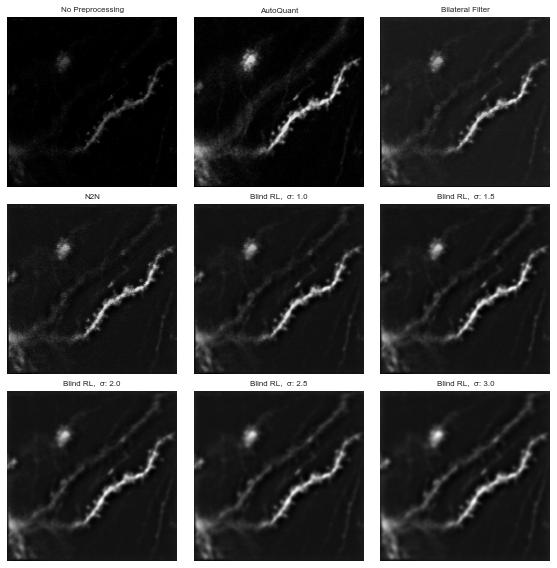

In [5]:
img1 = 'Tim_117_ArcCre_2017-05-08_A8.tif'
plane = 16
autoquant_res='D:/jo77pihe/Registered/20220203_AutoQuant_Averaged'
prefix = 'iter_3'
prefix2 = 'iter_2'

with paperStyle():
    print("\033[1m" + img1 + "\033[0m")
    fig=plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)

    n_h = 3
    n_w = 3
    #Raw
    f = io.imread(os.path.join(deconved_path, 'NoPre', prefix2+img1))
    ax = fig.add_subplot(n_h, n_w, 1)
    ax.imshow(f[plane, :, :],cmap='gray')
    ax.set_title('No Preprocessing')
    ax.axis('off')

    # AUtoQuant Img
    f = io.imread(os.path.join(autoquant_res, img1))
    ax = fig.add_subplot(n_h, n_w, 2)
    ax.imshow(f[plane, :, :],cmap='gray')
    ax.set_title('AutoQuant')
    ax.axis('off')

    #bilateral img
    f = io.imread(os.path.join(deconved_path, 'Bilateral', prefix+img1))
    ax = fig.add_subplot(n_h, n_w, 3)
    ax.imshow(f[plane, :, :],cmap='gray')
    ax.set_title('Bilateral Filter')
    ax.axis('off')

    # n2n Img
    f = io.imread(os.path.join(deconved_path, 'N2N', prefix+img1))
    ax = fig.add_subplot(n_h, n_w, 4)
    ax.imshow(f[plane, :, :],cmap='gray')
    ax.set_title('N2N')
    ax.axis('off')

    sm = ['1.0', '1.5', '2.0', '2.5', '3.0']
    for (i,l) in enumerate(sm):
        #Blind RL img
        f = io.imread(os.path.join(deconved_path,'Gaussian',prefix+l+'_'+img1))
        ax = fig.add_subplot(n_h, n_w, i+5)
        ax.imshow(f[plane, :, :],cmap='gray')
        ax.set_title('Blind RL,  σ: ' + l)
        ax.axis('off')

        plt.subplots_adjust(wspace=0.01, hspace=0.1)

plt.savefig('Deconv_preproc_visual_inspection.svg',bbox_inches='tight')
plt.savefig('Deconv_preproc_visual_inspection.pdf',bbox_inches='tight')

Tim_117_ArcCre_2017-05-08_A8.tif


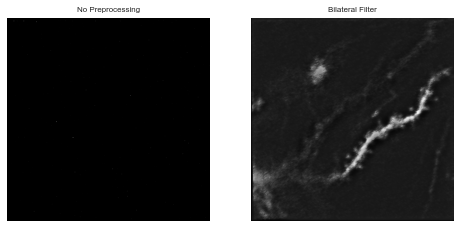

In [3]:
img1 = 'Tim_117_ArcCre_2017-05-08_A8.tif'
plane = 16
autoquant_res='D:/jo77pihe/Registered/20220203_AutoQuant_Averaged'
prefix = 'iter_4'
prefix2 = 'iter_4'

with paperStyle():
    print("\033[1m" + img1 + "\033[0m")
    fig=plt.figure()
    fig.set_figheight(8)
    fig.set_figwidth(8)

    n_h = 1
    n_w = 2
    #Raw
    f = io.imread(os.path.join(deconved_path, 'NoPre', prefix2+img1))
    ax = fig.add_subplot(n_h, n_w, 1)
    ax.imshow(f[plane, :, :],cmap='gray')
    ax.set_title('No Preprocessing')
    ax.axis('off')

    #bilateral img
    f = io.imread(os.path.join(deconved_path, 'Bilateral', prefix+img1))
    ax = fig.add_subplot(n_h, n_w, 2)
    ax.imshow(f[plane, :, :],cmap='gray')
    ax.set_title('Bilateral Filter')
    ax.axis('off')
plt.savefig('Deconv_preproc_vanishing.svg', bbox_inches='tight')
plt.savefig('Deconv_preproc_vanishing.pdf',bbox_inches='tight')

#### 1.2.2 Quantitative evaluation: SNR

*SNR*

In [12]:
path = deconved_path
bil_path = 'Bilateral'
gaussian = 'Gaussian'
n2n_path = 'N2N'
raw= 'NoPre'
sigma = '1.5_'

files = [f for f in os.listdir(os.path.join(data_path, 'BilateralFilter')) if f.endswith('.tif')]

res = np.zeros((len(files)*4,2))
labels= []

for (i,file) in enumerate(files):
    p_raw_n= io.imread(os.path.join(data_path,'Raw', file))
    p_raw_n = normalizer.normalize(p_raw_n)
    p_bil=io.imread(os.path.join(path,bil_path, 'iter_3'+file))
    p_bil = normalizer.normalize(p_bil)
    p_gau=io.imread(os.path.join(path,gaussian,'iter_3'+sigma+file))
    p_gau = normalizer.normalize(p_gau)
    p_n2n=io.imread(os.path.join(path,n2n_path, 'iter_3'+file))
    p_n2n = normalizer.normalize(p_n2n)
    p_raw= io.imread(os.path.join(path,raw, 'iter_3'+file))
    p_raw = normalizer.normalize(p_raw)
    
    snr_x = iqm.snr(p_raw_n)
    res[i*4,:] =[snr_x,iqm.snr(p_raw)]
    labels.append('No PreProc')
    res[i*4+1,:] =[snr_x,iqm.snr(p_bil)]
    labels.append('Bilateral')
    res[i*4+2,:] =[snr_x,iqm.snr(p_gau)]
    labels.append('Gaussian')
    res[i*4+3,:] =[snr_x,iqm.snr(p_n2n)]
    labels.append('N2N')


In [13]:
import pandas as pd

df = pd.DataFrame(res, columns=['Raw', 'Deconvolved'])
df['Denoiser'] = labels

In [14]:
df.to_pickle('deconv_preproc_snr.pkl')

In [23]:
df = pd.read_pickle('deconv_preproc_snr.pkl')

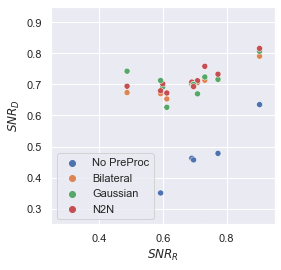

In [24]:
with paperStyle():
    sns.set(rc={'figure.figsize':(4,4)})
    p=sns.scatterplot(data=df, x="Raw", y="Deconvolved", hue="Denoiser")
    p.legend(loc='lower left')
    #p.legend(loc='center left', bbox_to_anchor=(1, 0.8), ncol=1)
    plt.title('SNR')
    plt.xlim(0.25,0.95)
    plt.ylim(0.25,0.95)
    plt.xlabel('$SNR_{R}$')
    plt.ylabel('$SNR_{D}$')
    plt.title('')
plt.savefig('Deconv_snr.svg',bbox_inches='tight')
plt.savefig('Deconv_snr.pdf',bbox_inches='tight')

#### 1.2.2.3 Quantitative evaluation: Reconstruction Error

In [53]:
deconvolver = REGISTRY['BlindRL'](args)
def calc(preprocessed_path, deconved_path, f, gauss= False):
    if gauss:
        it= 'iter_3'
    else:
        it='333'
    preprocessed = tif.imread(os.path.join(preprocessed_path, f))
    preprocessed = normalizer.normalize(preprocessed)

    img = tif.imread(os.path.join(deconved_path,it+f))
    psf = tif.imread(os.path.join(deconved_path, it+f[:-4]+'_psf.tif'))
    psf = deconvolver._pad(psf)
    img = deconvolver._pad(img)
    convolved = convolve(img, psf, mode='same')
    convolved = deconvolver._unpad(convolved)
    convolved = normalizer.normalize(convolved)
    return preprocessed, convolved

In [91]:
sigma = '1.5_'
# PSNR, SSIM, MSE
files = [f for f in os.listdir(os.path.join(data_path, 'BilateralFilter')) if (f.endswith('.tif') and (not 'psf' in f))]

result = np.zeros((len(files)*4,3))
labels = []
for (j,f) in enumerate(files):
    # Bil filter
    preprocessed, convolved = calc(os.path.join(data_path, 'BilateralFilter'), 
                                   os.path.join(deconved_path, 'Bilateral'), f)
    result[j*4,:] = [iqm.psnr(preprocessed, convolved), iqm.ssim(preprocessed, convolved),
                    iqm.mse(preprocessed, convolved)]   
    labels.append('Bilateral')

    # Bil filter
    preprocessed, convolved = calc(os.path.join(data_path, 'Neighbor2Neighbor'), 
                                   os.path.join(deconved_path, 'N2N'), f)
    result[j*4+1,:] = [iqm.psnr(preprocessed, convolved), iqm.ssim(preprocessed, convolved),
                    iqm.mse(preprocessed, convolved)]  
    labels.append('N2N')
    
    # Gaussian
    preprocessed, convolved = calc(os.path.join(data_path, 'GaussianFilter'), 
                                   os.path.join(deconved_path, 'Gaussian'), sigma+f, gauss=True)
    result[j*4+2,:] = [iqm.psnr(preprocessed, convolved), iqm.ssim(preprocessed, convolved),
                    iqm.mse(preprocessed, convolved)]
    labels.append('Gaussian')
    
    preprocessed, convolved = calc(os.path.join(data_path, 'Raw'), 
                                   os.path.join(deconved_path, 'NoPre'), f)
    result[j*4+3,:] = [iqm.psnr(preprocessed, convolved), iqm.ssim(preprocessed, convolved),
                    iqm.mse(preprocessed, convolved)]
    labels.append('No Pre')

In [92]:
import pandas as pd

df = pd.DataFrame(result, columns=['PSNR', 'SSIM', 'MSE'])
df['Denoiser'] = labels

In [93]:
df

,PSNR,SSIM,MSE,Denoiser
0,109.320003,0.780802,1.382883,Bilateral
1,107.380661,0.590719,2.161322,N2N
2,111.193067,0.876492,0.898419,Gaussian
3,103.556270,0.391348,5.213852,No Preproc
4,110.561674,0.820500,1.039007,Bilateral
5,107.990232,0.634483,1.878289,N2N
6,112.621547,0.916941,0.646593,Gaussian
7,107.629350,0.553192,2.041036,No Preproc
8,109.528538,0.772964,1.318050,Bilateral
9,107.935811,0.641668,1.901974,N2N


In [105]:
df.to_pickle('blind_rl_reconstruction_error.pkl')

In [20]:
import pandas as pd
df=pd.read_pickle('blind_rl_reconstruction_error.pkl')


In [21]:
df=df.replace('No Preproc', 'No Pre')

#### PSNR

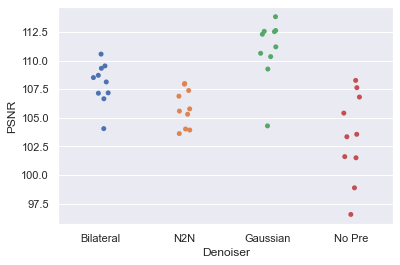

In [7]:
sns.set()
ax = sns.stripplot(x="Denoiser", y="PSNR", data=df)

*SSIM*

(0.0, 1.0)

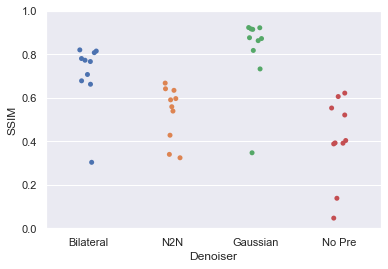

In [8]:
sns.set()
ax = sns.stripplot(x="Denoiser", y="SSIM", data=df, jitter=0.1)
ax.set_ylim(0,1)

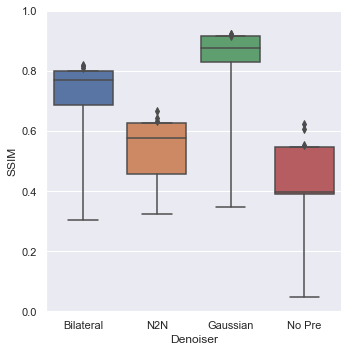

In [22]:
with paperStyle():
    sns.set(rc={'figure.figsize':(4,4)})
    ax=sns.catplot(x="Denoiser", y="SSIM", kind="box", data=df, whis=[0,1])
    ax.set(ylim=(0, 1))
plt.savefig('blind_rl_reconstruction_error.svg',bbox_inches='tight')
plt.savefig('blind_rl_reconstruction_error.pdf',bbox_inches='tight')

*MSE*


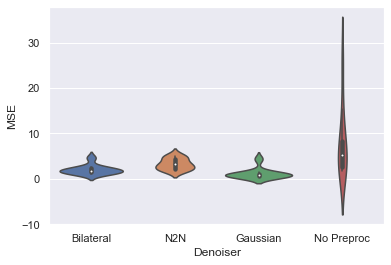

In [99]:
ax = sns.violinplot(x="Denoiser", y="MSE", data=df)

# 2. Find best Hyperparameters

### 2.1 Evaluate all hyperparameter combinations

Evaluate BL with number of inner loop iterations *i_psf, i_img = [1,....,5]* and outer iterations *i_rl = [1,...,10]*

#### 2.1.1 Obtain results

In [3]:
args = {}
args['data_path']= ''
args['source_folder']= 'D:\\jo77pihe\Registered\\20220203_AutoQuant_NotAveraged\\Blind_rl\\Raw'
args['target_folder']= ''
args['result_path'] = 'D:\\jo77pihe\\Registered\\20220215_Blind_RL_HypTuning_Sigma1'
args['psf'] = "C:/Users/jo77pihe/Documents/MasterThesis_OfSpinesAndDendrites/PSF"

max_iter_inner = 5
max_iter_outer = 10
sigma = 1.0

In [4]:
blind_rl = REGISTRY['BlindRL'](args)

In [ ]:
for i_psf in range(1,max_iter_inner+1):
    for i_img in range(1,max_iter_inner+1):
        blind_rl.predict(args['source_folder'], max_iter_outer, i_img, i_psf, sigma, eval_img_steps = True, save_intermediate_res = True)

*Create data structure with all results*

In [ ]:
from skimage.filters import gaussian

def preprocess(img, sigma=1):
    img = gaussian(img, sigma=sigma)
    return img

def _pad(img, pixels=10, planes=5):
    """
    Pad image
    :param img: Original image (np.array)
    :param pixels: amount to pad in x and y direction
    :param planes: amount to pad in z direction
    :return: padded image
    """
    return np.pad(img, ((planes, planes), (pixels, pixels), (pixels, pixels)), 'reflect')

def _unpad(img, pixels=10, planes=5):
    '''
    Crop the image by the number of pixels specified in x and y direction, by the amount of planes in z direction.
    :param img: Input image
    :param pixels: Image is reduced by the number of pixels specified in x and y direction on both sides
    :param planes: Image is reduced by the number of planes specified in z direction on both sides
    :return: Cropped image
    '''

    pixels = int(pixels)
    planes = int(planes)
    (z, x, y) = img.shape
    return img[planes:z - planes, pixels:x - pixels, pixels:y - pixels]

In [ ]:
sig = 1.0
iter_rl= np.tile(np.repeat(np.arange(1,max_iter_outer+1), (max_iter_inner)), max_iter_inner)
iter_img= np.tile(np.arange(1,max_iter_inner+1), max_iter_inner*max_iter_outer)
iter_psf= np.repeat(np.arange(1,max_iter_inner+1), max_iter_inner*max_iter_outer)

original_path = '..\\Registered\\Heatmap_reduced'
res_path = 'D:\\jo77pihe\\Registered\\Blind_RL_Heatmap'

files = [f for f in os.listdir(original_path) if f.endswith('.tif') and (not 'psf' in f)]

In [ ]:
lx = len(iter_rl)
df = pd.DataFrame()
df['Iter_RL'] = iter_rl#np.tile(iter_rl, len(files))
df['Iter_IMG'] = iter_img#np.tile(iter_img, len(files))
df['Iter_PSF'] = iter_psf#np.tile(iter_psf, len(files))
# names =  [f for f in files for i in range(lx)]
# df['File'] = names

df['psnr'] = np.zeros((len(df),1))
df['ssim'] = np.zeros((len(df),1))
df['mse'] = np.zeros((len(df),1))

for idx in range(0,len(df)):
    psnr = 0
    ssim = 0
    mse=0
    for fx in files:
        f = str(iter_rl[idx])+str(iter_psf[idx])+str(iter_img[idx])+ str(fx)
        img = np.float32(io.imread(os.path.join(res_path, f)))
        psf = np.float32(io.imread(os.path.join(res_path, f[:-4]+'_psf.tif')))

        org = np.float32(io.imread(os.path.join(original_path, fx)))
        org_sm = preprocess(org, sig)
        
        psf = _pad(psf)
        img = _pad(img)
        convolved = convolve(img, psf, mode='same')
        convolved =_unpad(convolved)

        # Scaling
        org_sm = normalizer.normalize(org_sm)
        convolved = normalizer.normalize(convolved)
        
        psnr += iqm.psnr(org_sm, convolved)
        ssim += iqm.ssim(org_sm, convolved)
        mse += iqm.mse(org_sm, convolved)

    df.loc[[idx],['psnr']]= psnr/len(files)
    df.loc[[idx],['ssim']]= ssim/len(files)
    df.loc[[idx],['mse']]= mse/len(files)
    print(idx)

In [ ]:
df.to_pickle("heatmap_1.pkl")

In [ ]:
df=pd.read_pickle('heatmap_1.pkl')

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)

#### 2.1.2 Plot result

In [ ]:
max_iter_outer=10
with paperStyle():
    fig = plt.figure()
    vmin = 0
    vmax = 1

    for i in range(max_iter_outer):
        ax = fig.add_subplot(4, 3, i+1)
        df_i = df.loc[df['Iter_RL'] == i+1]
        # df_sub = df_i.iloc[i*(max_iter_inner**2): (i+1)*(max_iter_inner**2)]
        df_i.drop(columns='Iter_RL', inplace=True)
        # r = np.reshape(np.array(df_sub['snr'], (max_iter_inner, max_iter_inner))
        df_pivot = df_i.pivot("Iter_PSF", "Iter_IMG", "ssim")
        # df_pivot = df_i.groupby(['Iter_IMG', 'Iter_PSF']).mean().unstack(level=0)
        if i == 5:
            sns.heatmap(df_pivot, vmin=vmin, vmax=vmax, cbar=True,
                        cbar_kws = dict(use_gridspec=False, pad=0.01, shrink=2.25),
                        xticklabels=False,
                        yticklabels=False, annot=True)
            cbar_kws = dict(use_gridspec=False, location="bottom", pad=0.01, shrink=0.25)

        else:
            sns.heatmap(df_pivot, vmin=vmin, vmax=vmax, cbar=False, yticklabels=True if i%3==0 else False,
                        xticklabels=True if i ==9 or i == 7 or i == 8 else False, annot=True)
        ax.set_title('RL_Iter = ' +str(i+1))
        atx = ax
    ax = fig.add_subplot(4, 3, 12)
    fig.colorbar(atx.collections[0], cax=ax)

    #% start: automatic generated code from pylustrator
    plt.figure(1).ax_dict = {ax.get_label(): ax for ax in plt.figure(1).axes}
    import matplotlib as mpl
    plt.figure(1).set_size_inches(25.230000/2.54, 23.090000/2.54, forward=True)
    plt.figure(1).ax_dict["<colorbar>"].set_visible(False)
    plt.figure(1).axes[0].set_position([0.125000, 0.712609, 0.198356, 0.167391])
    plt.figure(1).axes[0].title.set_fontsize(10)
    plt.figure(1).axes[0].get_xaxis().get_label().set_visible(False)
    plt.figure(1).axes[1].set_position([0.360623, 0.711598, 0.197432, 0.167391])
    plt.figure(1).axes[1].title.set_fontsize(10)
    plt.figure(1).axes[1].title.set_position([0.500000, 1.006035])
    plt.figure(1).axes[1].xaxis.labelpad = -5.440000
    plt.figure(1).axes[1].get_xaxis().get_label().set_visible(False)
    plt.figure(1).axes[1].get_yaxis().get_label().set_visible(False)
    plt.figure(1).axes[2].set_position([0.603643, 0.712609, 0.200205, 0.167391])
    plt.figure(1).axes[2].title.set_fontsize(10)
    plt.figure(1).axes[2].title.set_position([0.504618, 1.000000])
    plt.figure(1).axes[2].yaxis.labelpad = -4.720000
    plt.figure(1).axes[2].get_xaxis().get_label().set_visible(False)
    plt.figure(1).axes[2].get_yaxis().get_label().set_visible(False)
    plt.figure(1).axes[3].set_position([0.125925, 0.511739, 0.200205, 0.167391])
    plt.figure(1).axes[3].title.set_fontsize(10)
    plt.figure(1).axes[3].get_xaxis().get_label().set_visible(False)
    plt.figure(1).axes[4].set_position([0.358775, 0.511739, 0.203903, 0.167391])
    plt.figure(1).axes[4].spines['right'].set_visible(False)
    plt.figure(1).axes[4].spines['top'].set_visible(False)
    plt.figure(1).axes[4].title.set_fontsize(10)
    plt.figure(1).axes[4].yaxis.labelpad = -4.000000
    plt.figure(1).axes[4].get_xaxis().get_label().set_visible(False)
    plt.figure(1).axes[4].get_yaxis().get_label().set_visible(False)
    plt.figure(1).axes[5].set_position([0.602305, 0.511739, 0.201543, 0.167391])
    plt.figure(1).axes[5].title.set_fontsize(10)
    plt.figure(1).axes[5].xaxis.labelpad = -4.720000
    plt.figure(1).axes[5].get_xaxis().get_label().set_visible(False)
    plt.figure(1).axes[5].get_yaxis().get_label().set_visible(False)
    plt.figure(1).axes[7].set_position([0.125925, 0.295716, 0.199281, 0.167391])
    plt.figure(1).axes[7].title.set_fontsize(10)
    plt.figure(1).axes[7].title.set_position([0.500000, 0.987930])
    plt.figure(1).axes[7].xaxis.labelpad = -4.720000
    plt.figure(1).axes[7].get_xaxis().get_label().set_visible(False)
    plt.figure(1).axes[8].set_position([0.360623, 0.295716, 0.202055, 0.167391])
    plt.figure(1).axes[8].title.set_position([0.500000, 1.000000])
    plt.figure(1).axes[8].title.set_fontsize(10)
    plt.figure(1).axes[8].title.set_position([0.504549, 0.993978])
    plt.figure(1).axes[8].get_yaxis().get_label().set_visible(False)
    plt.figure(1).axes[9].set_position([0.602305, 0.295716, 0.200205, 0.167391])
    plt.figure(1).axes[9].title.set_fontsize(10)
    plt.figure(1).axes[9].get_yaxis().get_label().set_visible(False)
    plt.figure(1).axes[10].set_position([0.125000, 0.068586, 0.200205, 0.167391])
    plt.figure(1).axes[10].title.set_fontsize(10)
    plt.figure(1).axes[10].title.set_position([0.504618, 1.000000])
    plt.figure(1).axes[11].set_position([0.851144, 0.068315, 0.029166, 0.815951])
    #% end: automatic generated code from pylustrator
    plt.savefig('Heatmap_var_params.svg', bbox_inches='tight')
    plt.savefig('Heatmap_var_params.pdf', bbox_inches='tight')
